In [1]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# 2.1 $\quad$ Generación de carteras

## 1. Rentabilidad y volatilidad de una cartera con dos activos

Una cartera de activos define una colección de activos financieros, como acciones, bonos y otros instrumentos de inversión. La composición de la cartera se determina con el objetivo de alcanzar una meta financiera específica, como maximizar el rendimiento, minimizar el riesgo o encontrar cierto equilibrio entre ambos. La gestión de carteras implica la toma de decisiones estratégicas sobre la asignación de activos, la diversificación y el ajuste periódico para adaptarse a los posibles cambios en las condiciones del mercado.

Definir una cartera de activos implica especificar los diferentes instrumentos financieros o activos que la componen y la proporción en la que se invierte en cada uno. Si llamamos:

* $w_1$ a la proporción de la inversión en el activo $1$ $\Rightarrow w_2=1-w_1$. Debe cumplirse que $w_1 + w_2 = 1.0$ ya que representa el 100% de la inversión.

* $\bar R_p$ a la rentabilidad media o esperanza de la cartera $\Rightarrow \bar R_p=w_1 \bar R_1 + w_2 \bar R_2$. Es una suma ponderada de la rentabilidad de cada activo por el porcentaje de inversión $w_i$ en cada activo.

* Varianza $\sigma_{P}^2 = w_1^2 \sigma_{1}^2 + w_2^2 \sigma_{2}^2 + 2 w_1 w_2 \sigma_{12} \quad siendo \quad \sigma_{12} = \rho_{12} \sigma_1 \sigma_2$. La varianza de la cartera se ve afectada por las covarianzas ($\sigma_{12}$) entre los activos.

* Volatilidad $\sigma_{P} = \sqrt{\sigma_{P}^2}$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go

#from utils import dibuja_covar

plt.style.use('ggplot')


Definimos dos funciones:

* **calc_ret_cartera** una función que, dada una cartera, nos devuelve la rentabilidad esperada

* **calc_std_cartera** una función que, dada una cartera, nos devuelve la varianza de la cartera

* una cartera ejemplo con dos activos: **cartera**

In [3]:
def calc_ret_cartera(w1, w2, r1, r2):
    return w1 * r1 + w2 * r2

In [4]:
def calc_std_cartera(w1, w2, std1, std2, rho):
    return np.sqrt(w1**2 * std1**2 + w2**2 * std2**2 + 2 * w1 * w2 * std1 * std2 * rho)

In [5]:
#definimos una cartera con dos activos
ret1 = 0.2 #retornos esperados del activo 1
ret2 = 0.1 #retornos esperados del activo 2

std1 = 0.25 #volatilidad del activo 1
std2 = 0.15 #volatilidad del activo 2

p1 = 0.4 #peso del activo 1
p2 = 0.6 #peso del activo 2

---

### Caso 1:  $\quad$   $\rho_{12} = 1$

* Si $\rho_{12} = 1$ se dice que los activos son **perfectamente positivamente** correlacionados.

    - No hay beneficios de diversificación.

    - La rentabilidad de la cartera es igual a la suma ponderada de las rentabilidades de los activos.
        - $E(\tilde R_P) = w_1 E(\tilde R_1) + w_2 E(\tilde R_2)$
        $$$$

    - La volatilidad de la cartera es igual a la suma ponderada de las volatilidades de los activos.
        - $\sigma_P = w_1 \sigma_1 + w_2 \sigma_2$

Demostración de la estimación de la volatilidad:

- $cov(\tilde R_1, \tilde R_2) = \sigma(\tilde R_1) \sigma(\tilde R_2)$
    
- $\sigma_P² = w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2 + 2 w_1 w_2 \sigma_1 \sigma_2 = (w_1\sigma_1 + w_2\sigma_2)^2$


In [6]:
# definimos el coeficiente de correlación
coef_corr = 1

In [7]:
print(f'El retorno de la cartera es: {100*calc_ret_cartera(p1, p2, ret1, ret2):.2f} %')
print(f'La volatilidad de la cartera es: {100*calc_std_cartera(p1, p2, std1, std2, coef_corr):.2f} %')

El retorno de la cartera es:14.00 %
La volatilidad de la cartera es:19.00 %


Vamos a ir variando los pesos de los dos activos y ver cómo se comporta la rentabilidad y la volatilidad de la cartera.

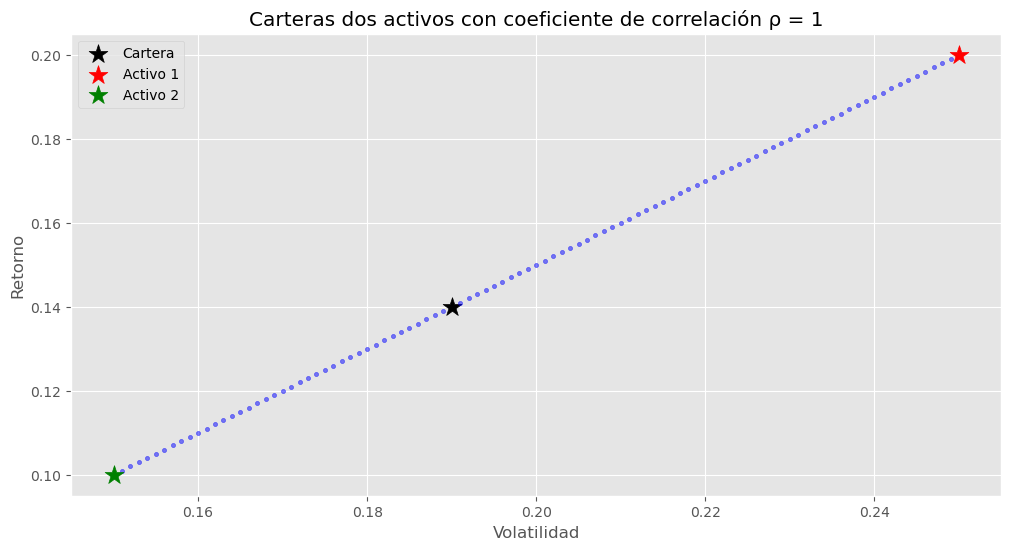

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.linspace(0, 1, 101) #generamos 101 puntos entre 0 y 1 que representan los pesos del activo 1

for i in x:
    reti = calc_ret_cartera(i, 1 - i, ret1, ret2) #calculamos el retorno de la cartera para cada peso
    stdi = calc_std_cartera(i, 1 - i, std1, std2, coef_corr) #calculamos la volatilidad de la cartera para cada peso
    if i == p1:
        plt.scatter(stdi, reti, color='black', marker='*', s=200, label='Cartera') #marcamos el punto de la cartera
    else:
        plt.scatter(stdi, reti, marker='.', color='blue', alpha=0.5) #marcamos el resto de puntos

plt.scatter(std1, ret1, color='red', marker='*', s=200, label='Activo 1') #marcamos el punto del activo 1
plt.scatter(std2, ret2, color='green', marker='*', s=200, label='Activo 2') #marcamos el punto del activo 2

plt.xlabel('Volatilidad')
plt.ylabel('Retorno')
plt.title('Carteras dos activos con coeficiente de correlación \u03C1 = 1')
plt.legend()
plt.show()

---

Vamos a construir carteras a partir de las rentabilidades de dos activos que descargamos.

In [18]:
# Descargar los precios de los activos
precios_pos_df = pd.read_csv('../data/precios_corr_pos.csv', index_col=0, parse_dates=True)
precios_pos_df.head()

,Activo 1,Activo 2
2010-01-04,117.000000,158.000000
2010-01-05,113.192375,156.263037
2010-01-06,111.121152,155.307702
2010-01-07,107.084666,153.467719
2010-01-08,105.076790,152.540900


In [19]:
# Calcular los retornos logarítmicos de los precios
retornos_pos_df = np.log(precios_pos_df).diff().dropna()

In [37]:
# Mostrar la matriz de covarianzas de los activos
retornos_pos_df.cov()

,Activo 1,Activo 2
Activo 1,0.000143,0.000062
Activo 2,0.000062,0.000028


In [39]:
# Mostrar la matriz de correlaciones de los activos
retornos_pos_df.corr()

,Activo 1,Activo 2
Activo 1,1.00000,0.98014
Activo 2,0.98014,1.00000


In [40]:
# Calcular la media y la desviación estándar de los retornos
med_pos = retornos_pos_df.mean()
std_pos = retornos_pos_df.std()

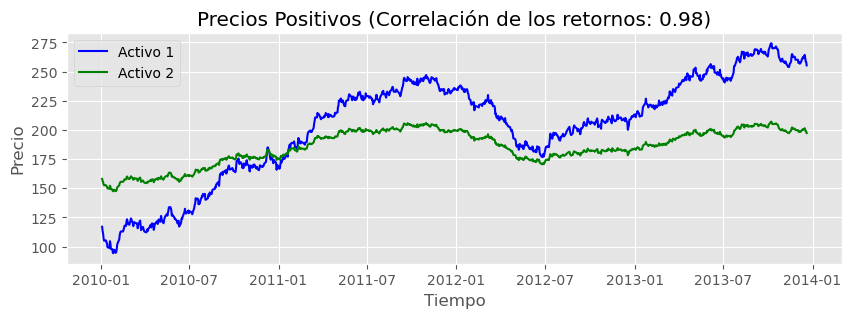

In [44]:
# Graficar precios_pos_df y mostrar coeficiente de correlación en el título
plt.figure(figsize=(10, 3))
corr_pos = retornos_pos_df.corr().iloc[0, 1]
plt.plot(precios_pos_df['Activo 1'], label='Activo 1', color='blue')
plt.plot(precios_pos_df['Activo 2'], label='Activo 2', color='green')
plt.title(f'Precios Positivos (Correlación de los retornos: {corr_pos:.2f})')
plt.xlabel("Tiempo")
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

Como se ve en la figura, tener una **correlación positiva** implica que cuando un activo sube, el otro también sube, es decir, están altamente correlados positivamente. Vamos a generar 1000 carteras aleatorias y a representarlas gráficamente.

In [45]:
# Generar pesos aleatorios
num_portfolios = 1000 #
np.random.seed(42)  # Fijar semilla para reproducibilidad
weights = np.random.random(size=(num_portfolios, 2))
weights = weights / np.sum(weights, axis=1, keepdims=True) # Normalizar para que la suma sea 1

In [46]:
# Función para calcular rentabilidad y riesgo de un activo individual
def asset_performance(returns):
    return returns.mean(), returns.std()

In [47]:
# Función para calcular retornos, rentabilidad y riesgo de la cartera
def portfolio_performance(weights, returns):
    portfolio_returns = returns @ weights.T
    return portfolio_returns.mean(axis=0), portfolio_returns.std(axis=0)

In [48]:
# Función para graficar en un eje específico
def plot_on_axis(ret_mean, ret_std, asset1_mean, asset1_std, asset2_mean, asset2_std, color, marker, label, corr):
    plt.scatter(ret_std, ret_mean, c=color, marker=marker, alpha=0.4, label=label)
    plt.scatter(asset1_std, asset1_mean, c='red', marker='*', s=150, label='Activo 1')
    plt.scatter(asset2_std, asset2_mean, c='green', marker='*', s=150, label='Activo 2')
    plt.title(f'{label} (Correlación: {corr:.2f})')
    plt.xlabel('Riesgo (Desviación Estándar)')
    plt.ylabel('Rentabilidad (Retorno Medio)')
    plt.legend(loc='upper left')
    plt.grid(True)

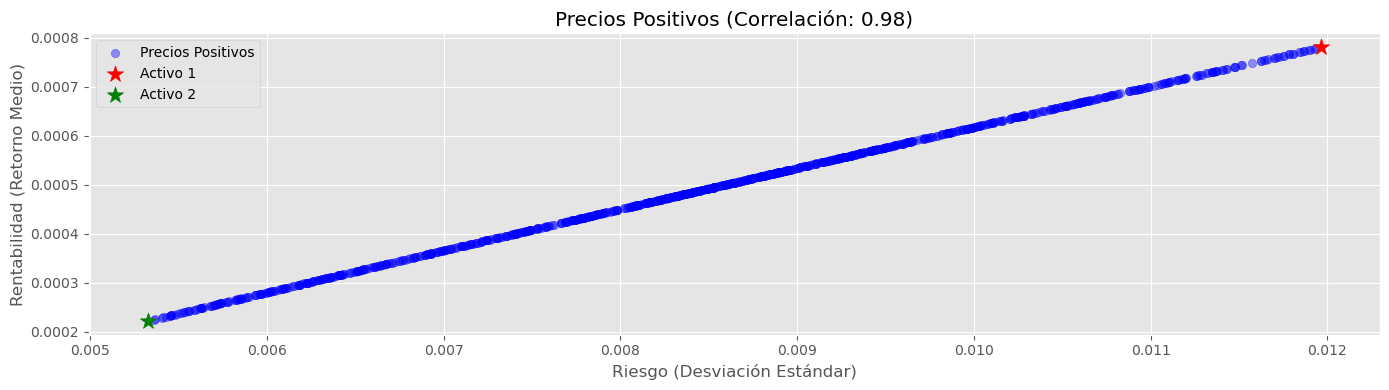

In [49]:
asset1_pos_mean, asset1_pos_std = asset_performance(retornos_pos_df['Activo 1'])
asset2_pos_mean, asset2_pos_std = asset_performance(retornos_pos_df['Activo 2'])

ret_pos_mean, ret_pos_std = portfolio_performance(weights, retornos_pos_df)

# Inicializar figura y ejes
plt.figure(figsize=(14, 4))

# Graficar en cada eje
plot_on_axis(ret_pos_mean, ret_pos_std, asset1_pos_mean, asset1_pos_std, asset2_pos_mean, asset2_pos_std, 'blue', 'o', 'Precios Positivos', corr_pos)
plt.tight_layout()
plt.show()

---

### Caso 2:  $\quad$  $\rho_{12} = -1$

* Si $\rho_{12} = -1$ se dice que los activos son **perfectamente pero negativamente** correlacionados.

    - Hay máximos beneficios de diversificación.

    - La rentabilidad de la cartera es igual (recordad que no depenede de las relaccciones entre activos).
        - $E(\tilde R_P) = w_1 E(\tilde R_1) + w_2 E(\tilde R_2)$
        $$$$
        

    - La volatilidad de la cartera es igual a la suma ponderada de las volatilidades de los activos.
        - $\sigma_P = w_1 \sigma_1 - w_2 \sigma_2\ \ \ \ \ \ $    OJO: el resultado debe ser positivo
        
     
Demostración de la estimación de la volatilidad:

- $cov(\tilde R_1, \tilde R_2) = -1 \times \sigma(\tilde R_1) \sigma(\tilde R_2)$
    
- $\sigma_P² = w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2 - 2 w_1 w_2 \sigma_1 \sigma_2 = (w_1\sigma_1 - w_2\sigma_2)^2$


In [12]:
# definimos el coeficiente de correlación
coef_corr_neg = -1

In [13]:
# calculamos la rentabilidad y volatilidad de la cartera con el nuevo coeficiente de correlación
print(f'El retorno de la cartera es:{100*calc_ret_cartera(p1, p2, ret1, ret2):.2f} %')
print(f'La volatilidad de la cartera es:{100*calc_std_cartera(p1, p2, std1, std2, coef_corr_neg):.2f} %')

El retorno de la cartera es:14.00 %
La volatilidad de la cartera es:1.00 %


Recordad que con $\rho_{12}=1$ nos dió:

* $E(\tilde R_p) = 14$%

* $\sigma_p = 19$%

y con el $\rho_{12}=-1$ y nos ha dado:

* $E(\tilde R_p) = 14$%

* $\sigma_p = 1$%

Gracias a la **diversificación**, obtenemos la misma rentabilidad pero **menor volatilidad**.

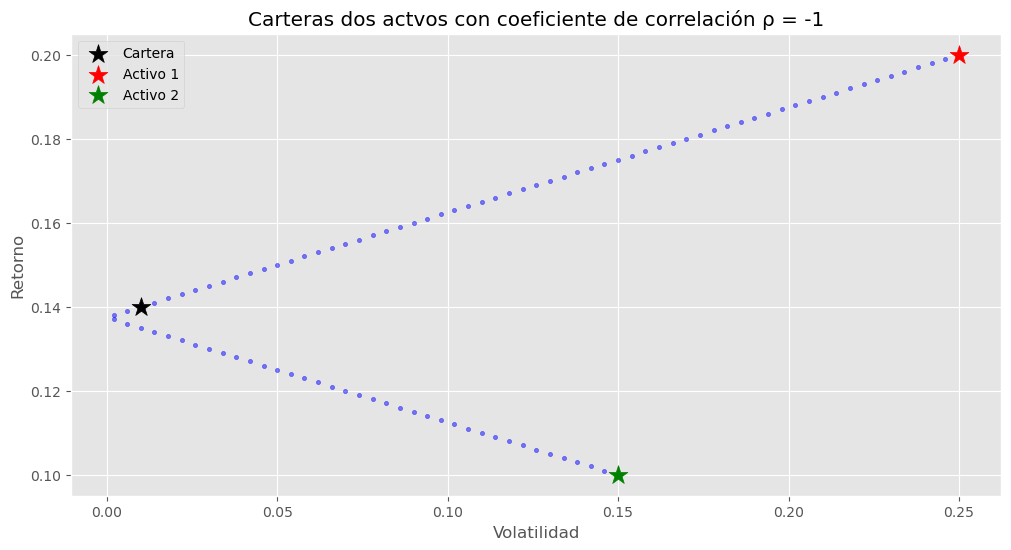

In [14]:
x = np.linspace(0, 1, 101) #generamos 101 puntos entre 0 y 1 que representan los pesos del activo 1

fig, ax = plt.subplots(figsize=(12, 6))

for i in x:
    reti = calc_ret_cartera(i, 1 - i, ret1, ret2) #calculamos el retorno de la cartera para cada peso
    stdi = calc_std_cartera(i, 1 - i, std1, std2, coef_corr_neg) #calculamos la volatilidad de la cartera para cada peso
    if i == p1:
        plt.scatter(stdi, reti, color='black', marker='*', s=200, label='Cartera') #marcamos el punto de la cartera
    else:
        plt.scatter(stdi, reti, color='blue', marker='.', alpha=0.5) #marcamos el resto de puntos

plt.scatter(std1, ret1, color='red', marker='*', s=200, label='Activo 1') #marcamos el punto del activo 1
plt.scatter(std2, ret2, color='green', marker='*', s=200, label='Activo 2') #marcamos el punto del activo 2

plt.xlabel('Volatilidad')
plt.ylabel('Retorno')
plt.title('Carteras dos actvos con coeficiente de correlación \u03C1 = -1')
plt.legend()
plt.show()

---

Vamos a construir carteras a partir de las rentabilidades de dos activos que descargamos.

In [50]:
precios_neg_df = pd.read_csv('../data/precios_corr_neg.csv', index_col=0, parse_dates=True)
precios_neg_df.head()

,Activo 1,Activo 2
2010-01-04,117.000000,158.000000
2010-01-05,113.169161,159.774582
2010-01-06,111.074723,160.767536
2010-01-07,107.015024,162.645138
2010-01-08,104.983933,163.609577


In [51]:
# Calcular los retornos logarítmicos para precios_neg_df
retornos_neg_df = np.log(precios_neg_df).diff().dropna()

In [52]:
# Calcular la media y la desviación estándar de los retornos
med_neg = retornos_neg_df.mean()
std_neg = retornos_neg_df.std()

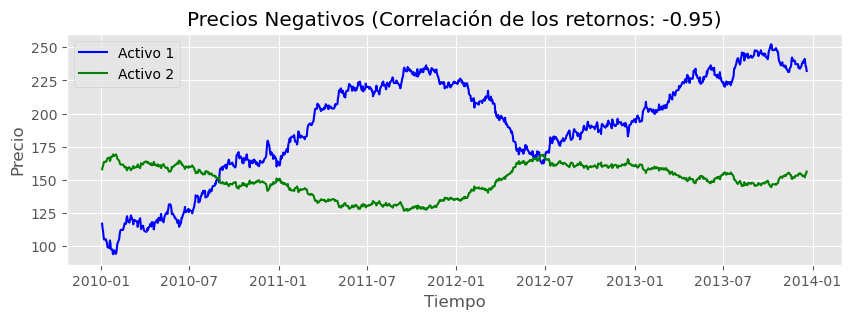

In [54]:
# Graficar precios_pos_df y mostrar coeficiente de correlación en el título
plt.figure(figsize=(10, 3))
corr_neg = retornos_neg_df.corr().iloc[0, 1]
plt.plot(precios_neg_df['Activo 1'], label='Activo 1', color='blue')
plt.plot(precios_neg_df['Activo 2'], label='Activo 2', color='green')
plt.title(f'Precios Negativos (Correlación de los retornos: {corr_neg:.2f})')
plt.xlabel("Tiempo")
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

Claramente podemos ver qué significa tener una **correlación negativa**. Cuando un activo sube, el otro baja, es decir, tienen un comportamiento opuesto. Vamos a generar 1000 carteras aleatorias.

In [55]:
# Generar pesos aleatorios
num_portfolios = 1000 #
np.random.seed(42)  # Fijar semilla para reproducibilidad
weights = np.random.random(size=(num_portfolios, 2))
weights = weights / np.sum(weights, axis=1, keepdims=True) # Normalizar para que la suma sea 1

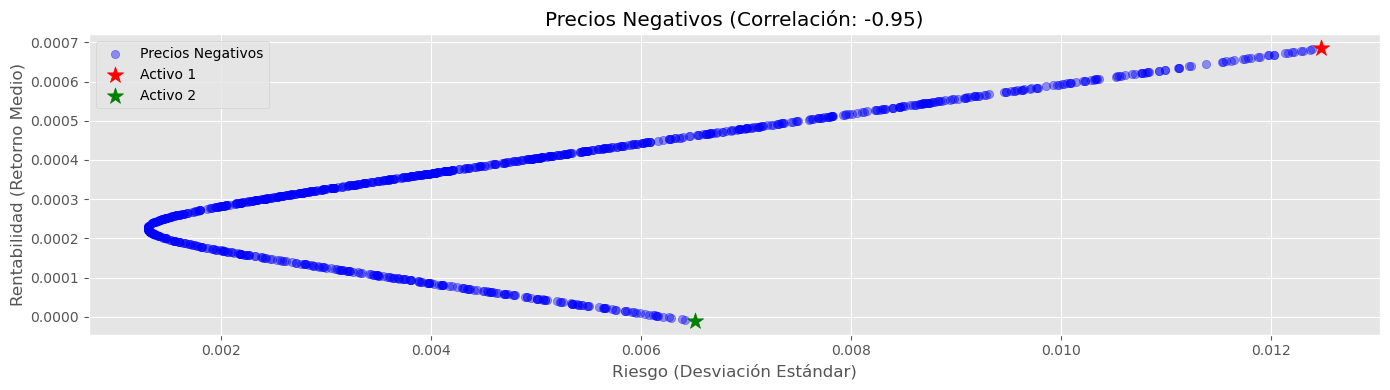

In [56]:
asset1_neg_mean, asset1_neg_std = asset_performance(retornos_neg_df['Activo 1'])
asset2_neg_mean, asset2_neg_std = asset_performance(retornos_neg_df['Activo 2'])

ret_neg_mean, ret_neg_std = portfolio_performance(weights, retornos_neg_df)

# Inicializar figura y ejes
plt.figure(figsize=(14, 4))

# Graficar en cada eje
plot_on_axis(ret_neg_mean, ret_neg_std, asset1_neg_mean, asset1_neg_std, asset2_neg_mean, asset2_neg_std, 'blue', 'o', 'Precios Negativos', corr_neg)
plt.tight_layout()
plt.show()

---

### Caso 3: $\quad$    $-1\leq \rho_{12} \leq 1$

* Si $-1 \leq \rho_{12} \leq 1$ se dice que los activos tienen correlación **lineal no perfecta**.

    - Hay beneficios de diversificación, a mayor correlación negativa mayor beneficio.

    - La rentabilidad de la cartera es igual (recordad que no depende de las relaciones entre activos).
        - $E(\tilde R_P) = w_1 E(\tilde R_1) + w_2 E(\tilde R_2)$
        $$$$
        
    - La varianza de la cartera es igual a:
        - $\sigma²(\tilde R_p)= \underset{Activo 1} {\underbrace{w_1²\sigma²(\tilde R_1)}}+\underset{Activo 2} {\underbrace{w_2²\sigma²(\tilde R_2)}}+ \underset{Relacion\ entre\ activos} {\underbrace{2w_1w_2 \rho_{12} \sigma_1 \sigma_2}}$
        $$$$

    - La volatilidad de la cartera es igual a la raiz cuadrada de la varianza.
        - $\sigma(\tilde R_p)= \sqrt{w_1²\sigma²(\tilde R_1)+w_2²\sigma²(\tilde R_2)+ 2w_1w_2 \rho_{12} \sigma_1 \sigma_2} $

        

In [57]:
x = np.linspace(0, 1, 101)
coef_corr_lst = [-1, -0.8, -0.5, 0, 0.5, 1]

# Definir un mapa de colores basado en coef_corr_lst
#colors = ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725', '#f0f921'] # con amarillos
colors = ['#440154', '#3b528b', '#21918c', '#5ec962', '#3366CC', '#FF6633']

# Ajustar el tamaño de la
layout_width = 1200  # Ancho en píxeles
layout_height = 700  # Altura en píxeles

# Crear la figura de plotly
fig = go.Figure()

for idx, coef_corr_i in enumerate(coef_corr_lst):
    ret_lst = []
    std_lst = []

    for i in x:
        reti = calc_ret_cartera(i, 1 - i, ret1, ret2) 
        stdi = calc_std_cartera(i, 1 - i, std1, std2, coef_corr_i) 

        ret_lst.append(reti)
        std_lst.append(stdi)

    fig.add_trace(go.Scatter(x=std_lst, y=ret_lst, mode='markers', 
                             name=f'Corr {coef_corr_i}', marker=dict(color=colors[idx], size=8, opacity=0.5)))

# Añadir puntos de activos individuales
fig.add_trace(go.Scatter(x=[std1], y=[ret1], mode='markers', marker=dict(color='red', size=20, symbol='star'),
                         name='Activo 1'))
fig.add_trace(go.Scatter(x=[std2], y=[ret2], mode='markers', marker=dict(color='green', size=20, symbol='star'),
                         name='Activo 2'))

# Configurar títulos y etiquetas

title_font_size = 20  # Tamaño de fuente del título

fig.update_layout(title='Cartera de dos activos variando el coeficiente de correlación',
                  font=dict(size=title_font_size),
                  title_x=0.5,
                  #xanchor='center',
                  xaxis_title='Volatilidad',
                  yaxis_title='Retorno',
                  )

# Mostrar el gráfico
fig.show()


---

Vamos a construir carteras a partir de las rentabilidades de dos activos que descargamos.

In [58]:
precios_cero_df = pd.read_csv('../data/precios_corr_cero.csv', index_col=0, parse_dates=True)
precios_cero_df.head()

,Activo 1,Activo 2
2010-01-04,117.000000,158.000000
2010-01-05,120.993339,158.417089
2010-01-06,123.250277,160.666274
2010-01-07,127.472476,159.712392
2010-01-08,129.666067,159.580555


In [59]:
# Calcular los retornos logarítmicos para precios_cero_df
retornos_cero_df = np.log(precios_cero_df).diff().dropna()

In [60]:
# Calcular la media y la desviación estándar de los retornos
med_cero = retornos_cero_df.mean()
std_cero = retornos_cero_df.std()

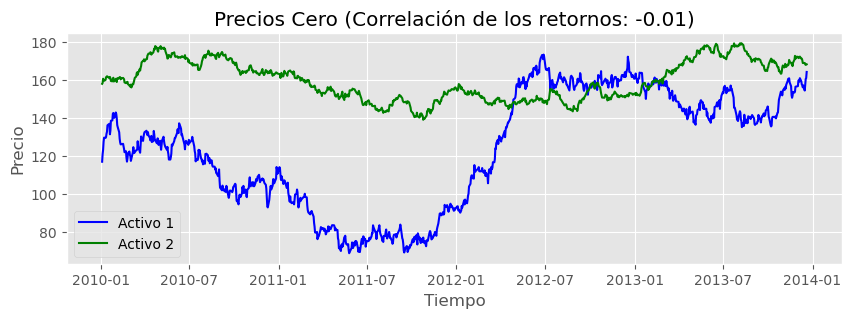

In [61]:
# Graficar precios_pos_df y mostrar coeficiente de correlación en el título
plt.figure(figsize=(10, 3))
corr_cero = retornos_cero_df.corr().iloc[0, 1]
plt.plot(precios_cero_df['Activo 1'], label='Activo 1', color='blue')
plt.plot(precios_cero_df['Activo 2'], label='Activo 2', color='green')
plt.title(f'Precios Cero (Correlación de los retornos: {corr_cero:.2f})')
plt.xlabel("Tiempo")
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

Como vemos en la figura, dos activos tienen **poca correlación** (ya sea positiva o negativa) cuando no hay relación en el comportamiento de los dos activos. Cuando uno sube, no podemos afirmar que el otro suba o baje. Vamos a generar, una vez más, 1000 carteras aleatorias.

In [62]:
# Generar pesos aleatorios
num_portfolios = 1000 #
np.random.seed(42)  # Fijar semilla para reproducibilidad
weights = np.random.random(size=(num_portfolios, 2))
weights = weights / np.sum(weights, axis=1, keepdims=True) # Normalizar para que la suma sea 1

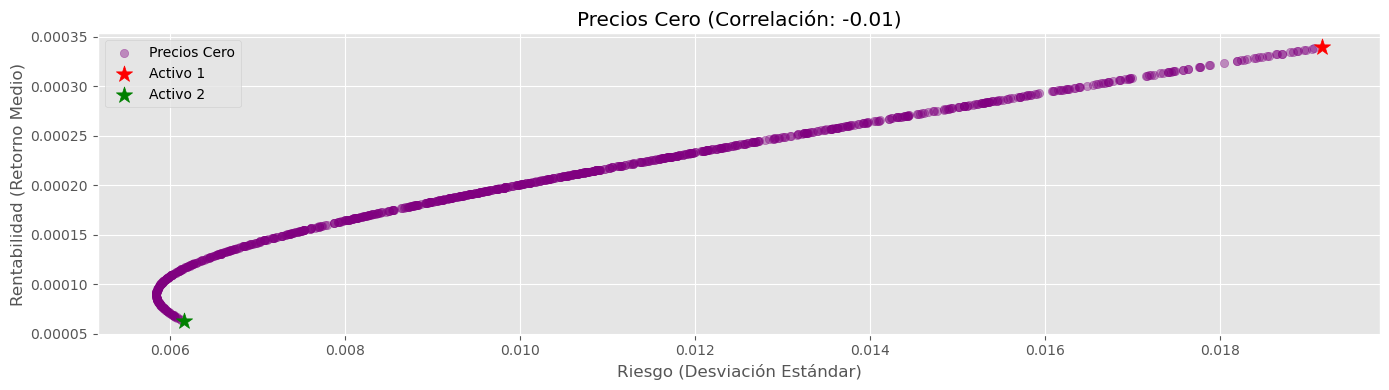

In [63]:
asset1_cero_mean, asset1_cero_std = asset_performance(retornos_cero_df['Activo 1'])
asset2_cero_mean, asset2_cero_std = asset_performance(retornos_cero_df['Activo 2'])

ret_cero_mean, ret_cero_std = portfolio_performance(weights, retornos_cero_df)

# Inicializar figura y ejes
plt.figure(figsize=(14, 4))

# Graficar en cada eje
plot_on_axis(ret_cero_mean, ret_cero_std, asset1_cero_mean, asset1_cero_std, asset2_cero_mean, asset2_cero_std, 'purple', 'o', 'Precios Cero', corr_cero)
plt.tight_layout()
plt.show()

## 2. Cálculo de la cartera de mínima volatilidad

Vamos a calcular la cartera de mínima varianza:

* Partimos de la fórmula de la varianza de la cartera:

    - $\sigma^2_p= w_1^2\sigma^2_1+w_2^2\sigma^2_2+ 2w_1w_2 \rho_{12} \sigma_1 \sigma_2 $
    $$$$

* Calculamos la derivada respecto de $w_1$, sustituimos $w_2=1-w_1$ e igualamos a 0:

    - $\dfrac{\partial \sigma^2_p}{\partial w_1}= 2w_1\sigma^2_1 - 2(1-w_1)\sigma^2_2 + 2(1-2w_1) \rho_{12} \sigma_1 \sigma_2 = 0$
    $$$$

* Despejamos $w_1$:

    - $w_1 = \dfrac{\sigma_2²-\rho_{12} \sigma_1 \sigma_2}{\sigma_1²+\sigma_2²-2 \rho_{12} \sigma_1 \sigma_2}$
    


  



En el caso de dos activos con correlación $\rho_{12} = -1$:

* $w_1 = \dfrac{\sigma_2²+\sigma_1 \sigma_2}{\sigma_1²+\sigma_2²+2 \sigma_1 \sigma_2} = \dfrac{\sigma_2(\sigma_1+\sigma_2)}{(\sigma_1+\sigma_2)²} = \dfrac{\sigma_2}{\sigma_1+\sigma_2}$

Si lo aplicamos al ejemplo de la cartera con dos activos que hemos estado usando:

In [16]:
p1 = std2/(std1+std2)
p2 = 1 - p1
print(f'El peso del activo 1 es: {100*p1:.2f}%')
print(f'El peso del activo 2 es: {100*p2:.2f}%')


El peso del activo 1 es: 37.50%
El peso del activo 2 es: 62.50%


In [17]:
# calculamos la rentabilidad y volatilidad de la cartera con los nuevos pesos
print(f'El retorno de la cartera es:{100*calc_ret_cartera(p1, p2, ret1, ret2):.2f} %')
print(f'La volatilidad de la cartera es:{100*calc_std_cartera(p1, p2, std1, std2, coef_corr_neg):.2f} %')

El retorno de la cartera es:13.75 %
La volatilidad de la cartera es:0.00 %


**CONCLUSIONES**

Recordad que con los pesos iniciales y $\rho_{12}=1$ nos dió:

* $E(\tilde R_p) = 14$%

* $\sigma_p = 19$%

Y hemos visto que con $\rho_{12}=-1$ y la fórmula de la cartera de mínima varianza nos ha dado:

* $E(\tilde R_p) = 13.75$%

* $\sigma_p = 0$%

Gracias a la **diversificación**, obtenemos casi la misma rentabilidad pero **sin riesgo**.